In [1]:
from crocoddyl import *
import pinocchio as pin
import numpy as np
from crocoddyl.diagnostic import displayTrajectory

In [2]:
# LOAD ROBOT
robot = loadKinton()
robot.initViewer(loadModel=True)
robot.display(robot.q0)

robot.framesForwardKinematics(robot.q0)

rmodel = robot.model

In [3]:
def uavPlacementModel(targetPos, targetQuat, integrationStep, frameName):
    # ACTUATION MODEL
    distanceRotorCOG = 0.1525
    cf = 6.6e-5
    cm = 1e-6
    actModel = ActuationModelUAM(robot.model, distanceRotorCOG, cf, cm)

    # COST MODEL
    # Create a cost model per the running and terminal action model.
    runningCostModel = CostModelSum(rmodel, actModel.nu)
    terminalCostModel = CostModelSum(rmodel, actModel.nu)

    state = StatePinocchio(rmodel)
    SE3ref = pin.SE3()
    SE3ref.translation = targetPos.reshape(3,1)
    SE3ref.rotation = targetQuat.matrix()

    wBasePos  = [1]
    wBaseOri  = [500]
    wArmPos   = [1]
    wBaseVel  = [10]
    wBaseRate = [10]
    wArmVel   = [10] 
    
    stateWeights   = np.array(wBasePos * 3 + wBaseOri * 3 + wArmPos * (robot.model.nv - 6) + wBaseVel * robot.model.nv)
    controlWeights = np.array([0.1]*4 + [100]*6)
    
    goalTrackingCost = CostModelFramePlacement(rmodel,
                                               frame=rmodel.getFrameId(frameName),
                                               ref=SE3ref,
                                               nu =actModel.nu)
    xRegCost = CostModelState(rmodel, 
                              state, 
                              ref=state.zero(), 
                              nu=actModel.nu,
                              activation=ActivationModelWeightedQuad(stateWeights))
    uRegCost = CostModelControl(rmodel, 
                                nu=robot.
                                model.nv-2,
                                activation = ActivationModelWeightedQuad(controlWeights))
    uLimCost = CostModelControl(rmodel, 
                                nu=robot.
                                model.nv-2,
                                activation = ActivationModelInequality(np.array([0.1, 0.1, 0.1, 0.1, -1, -1, -1, -1, -1, -1]), 
                                                                    np.array([5, 5, 5, 5, 1, 1, 1, 1, 1, 1])))

    # Then let's add the running and terminal cost functions
    runningCostModel.addCost(name="pos", weight=0.1, cost=goalTrackingCost)
    runningCostModel.addCost(name="regx", weight=1e-4, cost=xRegCost)
    runningCostModel.addCost(name="regu", weight=1e-6, cost=uRegCost)
    #runningCostModel.addCost(name="limu", weight=1e-3, cost=uLimCost)
    terminalCostModel.addCost(name="pos", weight=10, cost=goalTrackingCost)

    # DIFFERENTIAL ACTION MODEL
    dmodel = DifferentialActionModelUAM(rmodel, actModel, runningCostModel)
    model = IntegratedActionModelEuler(dmodel)
    model.timeStep =  integrationStep  
    return model   

In [4]:
# DEFINING THE SHOOTING PROBLEM & SOLVING

# Defining the time duration for running action models and the terminal one
dt = 1e-2

# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 50


# DEFINE POSITION WAYPOINTS
target_pos = [np.array([0,0,1])]
target_pos += [np.array([0,1,1])]
quat = pin.Quaternion(1, 0, 0, 0)
quat.normalize()
target_quat = [quat]*2

# Plot goal frame
for i in range(0,len(target_pos)):
    robot.viewer.gui.addXYZaxis('world/wp%i' % i, [1., 0., 0., 1.], .03, 0.5)
    robot.viewer.gui.applyConfiguration('world/wp%i' % i, 
                                        target_pos[i].tolist() + [target_quat[i][0], target_quat[i][1], target_quat[i][2], target_quat[i][3]])
    
robot.viewer.gui.refresh()

In [5]:
models = []
for i in range(0,len(target_pos)):
#    if (i==1):
#        T *=2
    models += [uavPlacementModel(target_pos[i], target_quat[i], dt, 'base_link')]*T

q0 = rmodel.referenceConfigurations["initial_pose"]
x0 = np.hstack([m2a(q0), np.zeros(robot.model.nv)])

problem = ShootingProblem(x0, models[:-1], models[-1])

# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverFDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

# Solving it with the DDP algorithm
ddp.solve()

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  3.51425e+00  1.27336e-04  1.22872e+01  1.00000e-09  1.00000e-09   0.5000     0
   1  2.32067e+00  4.16275e-05  3.89873e+00  1.00000e-09  1.00000e-09   0.5000     0
   2  1.17724e+00  5.80554e-05  2.00231e+00  1.00000e-09  1.00000e-09   1.0000     1
   3  1.09163e+00  1.06224e-05  2.37892e-01  1.00000e-09  1.00000e-09   1.0000     1
   4  1.06827e+00  1.78135e-06  7.83426e-02  1.00000e-09  1.00000e-09   1.0000     1
   5  1.06011e+00  1.57027e-06  2.81042e-02  1.00000e-09  1.00000e-09   1.0000     1
   6  1.05728e+00  1.83779e-07  1.06911e-02  1.00000e-09  1.00000e-09   1.0000     1
   7  1.05611e+00  3.19838e-07  4.55371e-03  1.00000e-09  1.00000e-09   1.0000     1
   8  1.05558e+00  3.47870e-08  2.19753e-03  1.00000e-09  1.00000e-09   1.0000     1
   9  1.05530e+00  9.59146e-08  1.17187e-03  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  1.05514e

([array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]),
  array([-8.31866622e-07, -3.25978404e-04,  7.24283918e-02,  4.63047162e-03,
         -1.18178567e-05,  5.23085205e-08,  9.99989279e-01, -1.27197423e-06,
          5.68737200e-04,  4.60060741e-05,  2.97355493e-05,  1.39762510e-05,
          2.71695010e-04,  2.40795347e-06,  9.40273736e-04,  7.24293836e+00,
          9.26097633e-01, -2.36357979e-03,  1.04617415e-05, -1.27197423e-04,
          5.68737200e-02,  4.60060741e-03,  2.97355493e-03,  1.39762510e-03,
          2.71695010e-02]),
  array([-2.17056282e-06, -1.84710123e-03,  1.69575435e-01,  1.81171485e-02,
         -1.95111637e-05,  1.27774207e-06,  9.99835871e-01, -3.59344339e-06,
          1.00033350e-02,  9.57875415e-05,  6.85058127e-05,  3.88288910e-05,
          2.51552967e-03,  1.70445776e-04,  6.89062970e-02,  9.71594535e+00,
          2.69753033e+00, -1.53806035e-03,  2.20340373e-04, -2.32146916e-04,
     

In [6]:
displayTrajectory(robot, ddp.xs, dt)

In [7]:
# Control trajectory
f1 = []
f2 = [];
f3 = [];
f4 = [];

for u in ddp.us:
    f1.append(u[0])
    f2.append(u[1])
    f3.append(u[2])
    f4.append(u[3])

# State trajectory
Xx = [];
Xy = [];
Xz = [];
Vx = [];
Vy = [];
Vz = [];


for x in ddp.xs:
    Xx.append(x[0])
    Xy.append(x[1])
    Xz.append(x[2])
    Vx.append(x[13])
    Vy.append(x[14])
    Vz.append(x[15])

Text(0.5,0,'[s]')

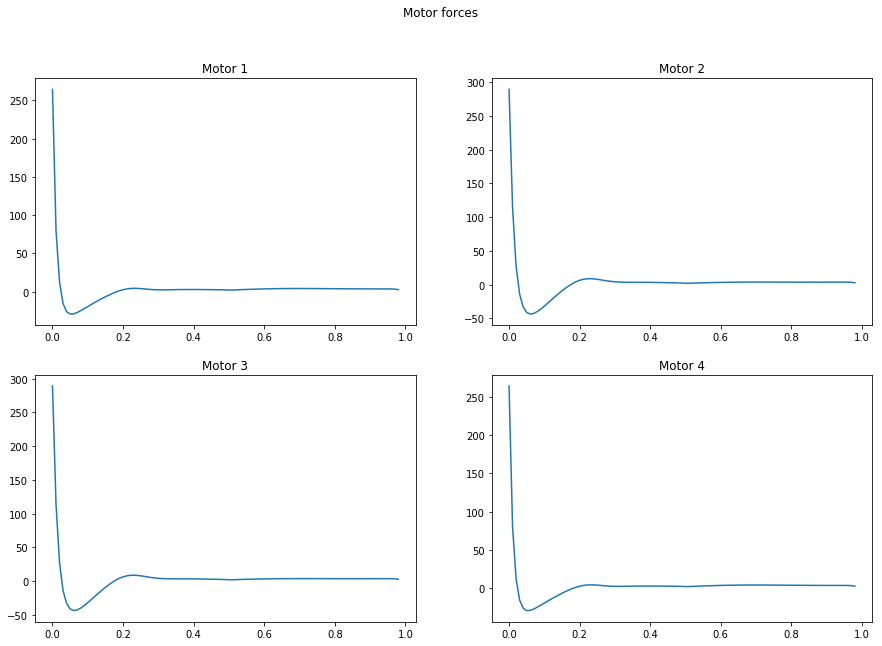

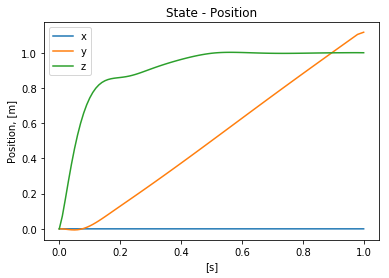

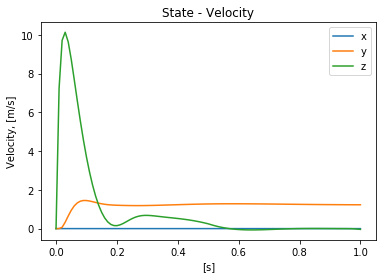

In [9]:
import matplotlib.pyplot as plt
t = np.arange(0., 1-dt, dt)

fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Motor forces')
axs[0, 0].plot(t,f1)
axs[0, 0].set_title('Motor 1')
axs[0, 1].plot(t,f2)
axs[0, 1].set_title('Motor 2')
axs[1, 0].plot(t,f3)
axs[1, 0].set_title('Motor 3')
axs[1, 1].plot(t,f4)
axs[1, 1].set_title('Motor 4')

plt.figure()
t = np.append(t, 1)
plt.plot(t,Xx,t,Xy,t,Xz)
plt.legend(['x','y','z'])
plt.title('State - Position')
plt.ylabel('Position, [m]')
plt.xlabel('[s]')

plt.figure()
plt.plot(t,Vx,t,Vy,t,Vz)
plt.legend(['x','y','z'])
plt.title('State - Velocity')
plt.ylabel('Velocity, [m/s]')
plt.xlabel('[s]')